# Feature selection
  * Sequential backward selection
  * L1 Regularization
  * Feature selection based on RF feature importance 

In [1]:
import pandas as pd

train_df = pd.read_csv('Urban land cover/training.csv')
test_df = pd.read_csv('Urban land cover/testing.csv')
combined_df = pd.concat([train_df, test_df])
combined_df

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,building,1.36,3146,0.90,244.97,1.44,1.39,229.86,252.47,252.58,...,7.58,1.51,0.63,0.84,6.85,1.96,0.47,-0.04,784,1911.96
503,grass,2.51,428,1.55,166.02,2.16,2.61,210.11,135.89,152.04,...,18.91,1.14,0.86,0.67,7.70,1.80,0.50,0.22,1020,801.65
504,concrete,2.45,659,1.38,219.30,1.68,2.53,189.64,233.14,235.12,...,14.67,2.21,0.74,0.78,7.47,1.70,0.74,-0.09,2596,1243.03
505,building,1.90,89,1.01,219.88,2.02,2.01,184.82,235.18,239.65,...,37.11,5.26,0.75,0.85,8.47,1.30,0.94,-0.12,726,1470.63


In [2]:
# Number of examples
print(len(train_df), 'train instances')
print(len(test_df), 'test instances')

168 train instances
507 test instances


## Why do we need feature selection?
* Main reason: Curse of dimensionality
* Also makes for a smaller and simpler model!

In [3]:
# One column ("class") is not a feature; all others are
features = [f for f in train_df.columns if f != 'class']
print(len(features), 'features')

# There are way too many features in the dataset, especially for KNN or a linear model

147 features


In [4]:
# Computing the correlation matrix for features
corr = train_df[features].corr().stack().reset_index()
corr.columns = ['feature1', 'feature2', 'r']
corr = corr[corr.feature1 != corr.feature2] # Excluding self-correlations
corr

,feature1,feature2,r
1,BrdIndx,Area,-0.085323
2,BrdIndx,Round,0.812346
3,BrdIndx,Bright,-0.130840
4,BrdIndx,Compact,0.850907
5,BrdIndx,ShpIndx,0.927880
...,...,...,...
21603,GLCM3_140,GLCM2_140,-0.606967
21604,GLCM3_140,Dens_140,0.016892
21605,GLCM3_140,Assym_140,0.067005
21606,GLCM3_140,NDVI_140,-0.385285


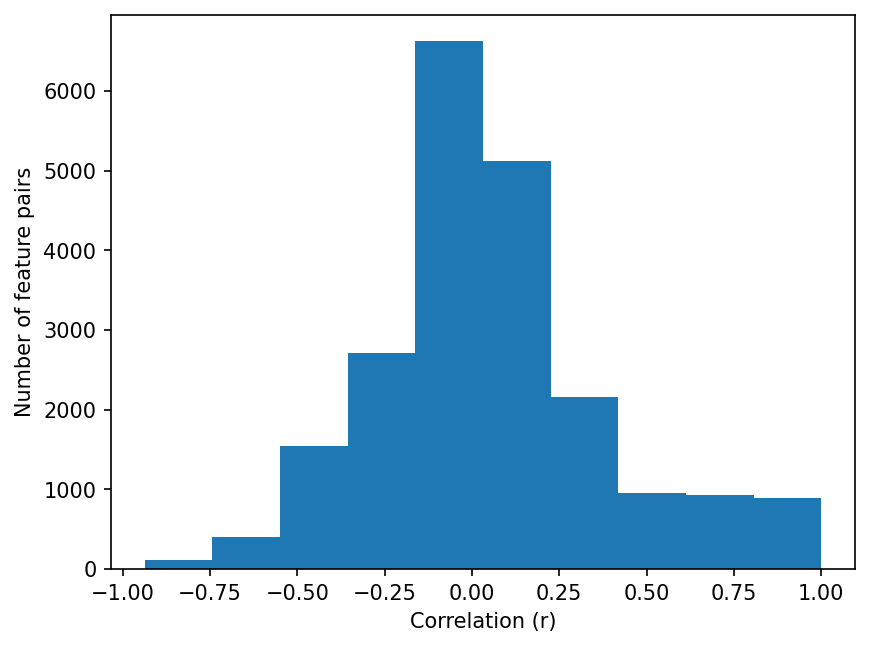

In [5]:
# Plot the correlations
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.xlabel('Correlation (r)')
plt.ylabel('Number of feature pairs')
_ = plt.hist(corr.r)

# Lots of features are pretty correlated with each other
# There are thousands of pairs with high positive correlations (close to 1.0). 

In [ ]:
# Now let's look at the maximum correlation between every feature and every other feature
abs_corr = corr.copy()
# # ignore whether correlation is positive or negative and focusing solely on strength of correlation
abs_corr['r'] = abs_corr.r.abs() 
# find maximum absolute correlation for each feature
max_corr = abs_corr.groupby('feature1').r.max()
with pd.option_context('display.max_rows', None):
    print(max_corr)

In [ ]:
plt.figure(dpi=150)
plt.xlabel('Correlation (r)')
plt.ylabel('Number of features')
_ = plt.hist(max_corr)
# Each feature has at least one other feature that it is very highly correlated with
# So, we should remove some of these!

## Sequential backward selection
### Manually first

In [ ]:
# Run through *one* iteration manually, i.e., removing one feature
from sklearn import neighbors, metrics, model_selection

model = neighbors.KNeighborsClassifier(5)
xval = model_selection.KFold(2, shuffle=True) # 2-fold for spee
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model, train_df[features], train_df['class'], cv=xval, scoring=scorer)
print('Kappa:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())

best_kappa = -1
best_i = None
for i in range(len(features)):
    subset_features = features[:i] + features[i + 1:] #skip i-th feature
    new_result = model_selection.cross_validate(model, train_df[subset_features], train_df['class'], cv=xval, scoring=scorer)
    test_kappa = new_result['test_score'].mean()
    if test_kappa > best_kappa:
        best_kappa = test_kappa
        best_i = i
print('Best kappa:', best_kappa)
print('Best feature to remove:', features[best_i])

### Scikit-learn implementation

In [ ]:
print('before:', train_df[features].shape)

In [ ]:
from sklearn import feature_selection
model = neighbors.KNeighborsClassifier(5)
xval = model_selection.KFold(2, shuffle=True) # 2-fold for speed
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

fs = feature_selection.SequentialFeatureSelector(
    model, direction='backward',
    n_features_to_select=100,
    scoring=scorer,
    cv=xval)

fs.fit(train_df[features], train_df['class'])

In [ ]:
train_X = fs.transform(train_df[features])
print('after:', train_X.shape)

In [ ]:
test_X = fs.transform(test_df[features])
test_X.shape

In [ ]:
# Model performance after FS
model.fit(train_X, train_df['class'])
preds = model.predict(test_X)
print('FS kappa:', metrics.cohen_kappa_score(test_df['class'], preds))

# Versus without FS
model.fit(train_df[features], train_df['class'])
preds = model.predict(test_df[features])
print('No FS kappa:', metrics.cohen_kappa_score(test_df['class'], preds))

In [ ]:
# Now let's try FS in a pipeline
# 145 features as this is a bit slow
from sklearn import pipeline

pipe = pipeline.Pipeline([
    ('fs', feature_selection.SequentialFeatureSelector(model, n_features_to_select=145,
        direction='backward', scoring=scorer, cv=xval)),
    ('model', model)
])

result = model_selection.cross_validate(pipe, combined_df[features], combined_df['class'], cv=xval, scoring=scorer)
print('Kappa:', result['test_score'].mean())

## RF feature importance

### Importance as Gini impurity decrease

In [ ]:
# Plot single tree
from sklearn import tree

model = tree.DecisionTreeClassifier(min_samples_leaf=20)
model.fit(train_df[features], train_df['class'])
plt.figure(dpi=300, figsize=(8, 4))
_ = tree.plot_tree(model, feature_names=features, filled=True)
# filled=True DT plot with different colors representing different predicted classes at each node. 
# Each color corresponds to a unique class and color intensity is based on the purity of the node. 

### Importance for a Random Forest

In [ ]:
# Plot importances for a whole forest
from sklearn import ensemble

model = ensemble.RandomForestClassifier(max_depth=5)
model.fit(train_df[features], train_df['class'])
model.feature_importances_

In [ ]:
model.feature_importances_.sum() # Feature importances sum to 1

In [ ]:
plt.figure(dpi=150)
plt.xlabel('Importance')
plt.ylabel('Number of features')
_ = plt.hist(model.feature_importances_, bins=50)

Save as a DataFrame, useful for interpretation (including in class projects).

In [ ]:
feat_df = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feat_df.sort_values('importance', ascending=False)

In [ ]:
feat_df.importance.describe()
good_features = feat_df[feat_df.importance > 0.003335]
good_features.feature

### Feature importance for selection

In [ ]:
#SelectFromModel: Meta-transformer for selecting features based on importance weights.
# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectFromModel.html
fs = feature_selection.SelectFromModel(
    ensemble.RandomForestClassifier(max_depth=5),
    threshold='median') 
# Features whose absolute importance value is greater or equal than the (median) threshold are kept while the others are discarded. 

fs.fit(train_df[features], train_df['class'])
train_X = fs.transform(train_df[features])
print('train shape', train_X.shape)

test_X = fs.transform(test_df[features])
print('test shape', test_X.shape)

model = neighbors.KNeighborsClassifier(5)
model.fit(train_X, train_df['class'])
preds = model.predict(test_X)
print('Kappa FS:', metrics.cohen_kappa_score(test_df['class'], preds))

# Versus original:
model.fit(train_df[features], train_df['class'])
preds = model.predict(test_df[features])
print('Kappa no FS:', metrics.cohen_kappa_score(test_df['class'], preds))

### Using a pipeline

In [ ]:
from sklearn import pipeline, preprocessing

pipe = pipeline.Pipeline([
    ('fs', feature_selection.SelectFromModel(
        ensemble.RandomForestClassifier(min_samples_leaf=5),
        threshold='median')),
    ('scaling', preprocessing.StandardScaler()),
    ('model', neighbors.KNeighborsClassifier(5)),
])
xval = model_selection.KFold(10, shuffle=True)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(pipe,
    combined_df[features], combined_df['class'],
    cv=xval, scoring=scorer,
    return_train_score=True, return_estimator=True)

print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

## L1 feature selection

In [ ]:
from sklearn import linear_model

# NOTE: C here is **inverse** of regularization strength. Smaller values specify stronger regularization.
model = linear_model.LogisticRegression('l1', solver='liblinear', C=.1)
model.fit(train_df[features], train_df['class'])
# Row dimension is one set of coefficients per class
coef = pd.DataFrame(model.coef_)
coef

In [ ]:
feature_coeffs = pd.DataFrame({'feature': features, 'coef': coef.iloc[0]})
feature_coeffs

## Overfitting feature selection
* Generate a random dataset
* Select features based on testing data

In [ ]:
import numpy as np
new_data = np.random.random([200, 1000])
features = ['col' + str(i) for i in range(1000)]
new_df = pd.DataFrame(new_data, columns=features)
new_df['label'] = np.random.randint(0, 2, 200)

model = ensemble.RandomForestClassifier()
train_df = new_df.iloc[:100]
test_df = new_df.iloc[100:]
model.fit(new_df[features], new_df.label)  # Oops! Used whole dataset for feature selection!
feat_df = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feat_df.sort_values('importance', ascending=False)

top_features = feat_df[feat_df.importance > feat_df.importance.quantile(.95)]
new_features = top_features.feature.tolist()

# Now because of overfitting feature selection, we end up with kappa that *seems* above chance
# even though that is impossible with random data -- illustrates the dangers of overfitting
model.fit(train_df[new_features], train_df.label)
preds = model.predict(test_df[new_features])
print('Kappa:', metrics.cohen_kappa_score(test_df.label, preds))
